# 03 - Algorithm

So, we separated some samples in [01 - Take Samples](01_take_samples.ipynb) and rescaled the images and created grayscale copies in [02 - Preprocess](02_preprocess.ipynb). Now it is the time to see if we can fit a machine learning algorithm that can perform the task: Detecting objects in images by using outlier detection. For this we will perform the following tasks:

* Using a method to partition an image in non-overlapping patches of a predefined shape.
* Creating a set of features to describe the block.
    * Currently implemented: **Intensity histogram**
* Fitting an outlier detection algorithm to predict if that block contains an object.
* Rebuild the image and visualize the outcome :)

If the task is successful we can later try to create a herustic to find the bounding boxes.

## Imports

In [1]:
import pandas as pd
import numpy as np
import imageio
from skimage.util import view_as_blocks
from sklearn.ensemble import IsolationForest
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt

from funcs.preprocessing import read_data
from funcs.plot import show_image
from funcs.ml import read_images, images_as_patches, prediction_intensities, reconstruct_image, IntensityHistogram, train_isoforest, eval_model

In [2]:
plt.rcParams['figure.figsize'] = (12,8)

Let's start with the grayscale images

In [3]:
gray_train_val_images, train_val_annotations = read_data('gray_', 'resized_')

## Creating patches

To split an image into patches we can use the `view_as_blocks` function from `skimage`. It will create non-overlapping blocks of the image, given a patch size.

Since we rescaled our images to be 1024x1024, we can use any power of 2 as the block size and we will have the complete image as blocks.

Let's try a silly example using 512 as the block size.

In [4]:
img = imageio.imread(gray_train_val_images.iloc[0, -1])

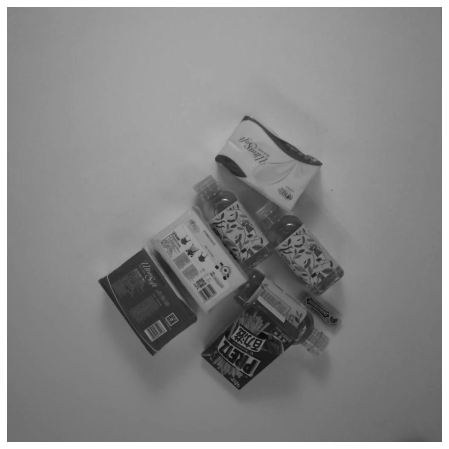

In [5]:
plt.imshow(img, cmap='gray')

plt.axis('off')
plt.show()

In [6]:
img_blocks = view_as_blocks(img, (512,512)).reshape(-1, 512, 512)

img_blocks.shape

(4, 512, 512)

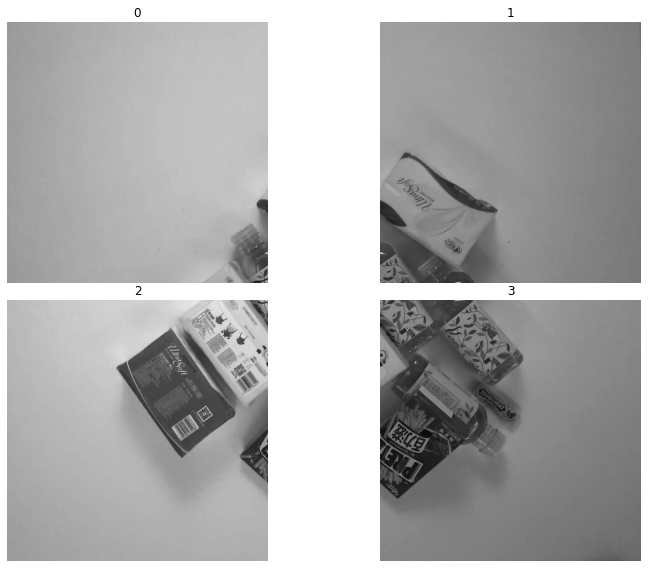

In [7]:
fig, axs = plt.subplots(nrows=2, ncols=2)

axs = axs.flatten()

for i, ax in zip(range(img_blocks.shape[0]), axs):

    ax.imshow(img_blocks[i, :, :], cmap='gray')
    ax.set_title(str(i))
    ax.axis('off')

fig.tight_layout(h_pad=0.1)
plt.show()

Of course there is a trade-off when selecting the patch size where smaller sizes will lead to more specific information, and possibly better to detect nuances in the images, while bigger blocks will lead to more information at the cost of the specificity.

We can also easily reconstruct the image

(512, 1024)


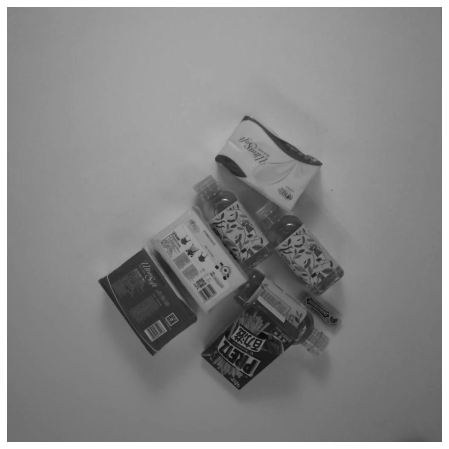

In [8]:
# We first have to stack the images along the rows (ie expand the images row-wise)
first_half = np.hstack(img_blocks[:2, :, :])
print(first_half.shape)
second_half = np.hstack(img_blocks[2:, :, :])

# Then just put each half on top of each other
reconstructed_image = np.vstack((first_half, second_half))

plt.imshow(reconstructed_image, cmap='gray')

plt.axis('off')
plt.show()

## Histogram

One way to describe an image is using an histogram of intensities. The histogram will compute the frequency of each intensity, given that it belongs to a specific bin.

The bin size is usually learned from the data, and since we will be working with images having some varying distribution of intesities, it would be wise to standardize the bin ranges.

We can do that by setting the `bins` and `range` parameters of `numpy.histogram`

In [9]:
img2 = imageio.imread(gray_train_val_images.iloc[1, -1]) # Let's take another image

In [10]:
# Even tough the images have different distributions, its edges appear to be the same
hist, edges = np.histogram(img, bins=128, range=(0, 255))
hist2, edges2 = np.histogram(img2, bins=128, range=(0, 255))

diff_edges = edges-edges2

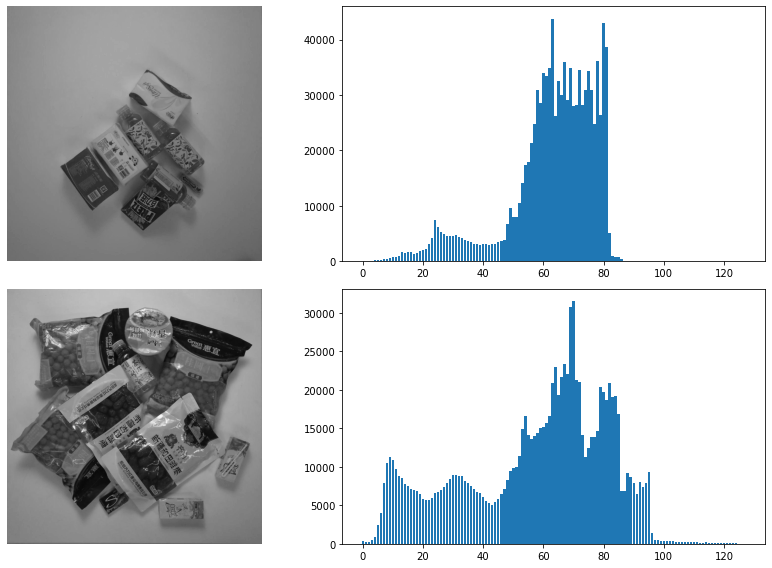

In [11]:
fig, axs = plt.subplots(nrows=2, ncols=2)

axs = axs.flatten()

axs[0].imshow(img, cmap='gray')
axs[0].axis('off')
axs[1].bar(range(128), hist)

axs[2].imshow(img2, cmap='gray')
axs[2].axis('off')
axs[3].bar(range(128), hist2)

fig.tight_layout()
plt.show()

The edges are also the same

In [12]:
print(diff_edges.sum())
print(diff_edges.max())
print(diff_edges.min())

0.0
0.0
0.0


Let's see the histogram distribution of our patches defined beforehand to get a general idea of what we are trying to accomplish

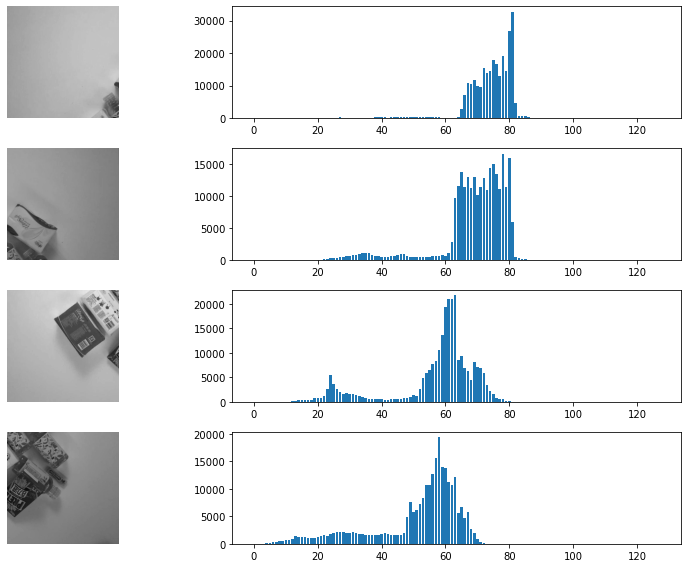

In [13]:
fig, axs = plt.subplots(nrows=4, ncols=2)

for i in range(img_blocks.shape[0]):

    hist, edges = np.histogram(img_blocks[i, :, :], bins=128, range=(0, 255))
    axs[i, 0].imshow(img_blocks[i, :, :], cmap='gray')
    axs[i, 0].axis('off')
    axs[i, 1].bar(range(128), hist)

fig.tight_layout()
plt.show()

## Feature descriptors

Now we have to wrap everything up. Read all our images, take the *n* patches of whichever size we want and take the intensity histogram of each of them.

For the first experiments, we will use a patch size of 64x64, which for each image should yield 256 patches.

In [14]:
train_idx = gray_train_val_images.loc[gray_train_val_images['source']=='train'].index.max()
val_idx = gray_train_val_images.loc[gray_train_val_images['source']=='validation'].index.max()

In [15]:
imgs_array = read_images(gray_train_val_images['file_name'])

train_imgs = imgs_array[:train_idx+1, :, :].copy()
val_imgs = imgs_array[train_idx+1:val_idx+1, :, :].copy()
test_imgs = imgs_array[val_idx+1:, :, :].copy()

In [16]:
print(train_imgs.shape)
print(val_imgs.shape)
print(test_imgs.shape)

(70, 1024, 1024)
(20, 1024, 1024)
(10, 1024, 1024)


In [17]:
gray_patch_size = (1, 64, 64)
train_set = images_as_patches(train_imgs, gray_patch_size)
val_set = images_as_patches(val_imgs, gray_patch_size)


print(train_set.shape)

(17920, 4096)


### Color images

Let's take this opportunity to also read and prepare the color images

In [18]:
color_train_val_images, _ = read_data('resized_', 'resized_')

In [19]:
color_imgs_array = read_images(color_train_val_images['file_name'], color=True)

color_train_imgs = color_imgs_array[:train_idx+1, :, :].copy()
color_val_imgs = color_imgs_array[train_idx+1:val_idx+1, :, :].copy()
color_test_imgs = color_imgs_array[val_idx+1:, :, :].copy()

In [20]:
print(color_train_imgs.shape)
print(color_val_imgs.shape)
print(color_test_imgs.shape)

(70, 1024, 1024, 3)
(20, 1024, 1024, 3)
(10, 1024, 1024, 3)


In [21]:
color_patch_size = (1, 64, 64, 3)
color_train_set = images_as_patches(color_train_imgs, color_patch_size)
color_val_set = images_as_patches(color_val_imgs, color_patch_size)

print(color_train_set.shape)

(17920, 4096, 3)


## Fiting the IsoForest

We will use the Isolation Forest Algorithm. It has a nice propety that it returns the outlier propensity for each sample (i.e our patches), which we can later use as intensities to visualize how our detection algorithm is performing.

In [22]:
models_dict = {
    'gray_64': {'method': 'grayscale', 'nbins': 64},
    'gray_128': {'method': 'grayscale', 'nbins': 128},
    'gray_255': {'method': 'grayscale', 'nbins': 255},
    'color_16': {'method': 'color', 'nbins': 16},
    'color_32': {'method': 'color', 'nbins': 32},
    'color_64': {'method': 'color', 'nbins': 64},
    'color_128': {'method': 'color', 'nbins': 128}
}

In [23]:
for feature_type, params in models_dict.items():
    print(f'Fitting iso forest for: {feature_type}')

    if params['method']=='grayscale':
        pipeline = train_isoforest(train_set, params['nbins'])
        params['train_score'] = eval_model(train_set, pipeline)
        params['val_score'] = eval_model(val_set, pipeline)
    else:
        pipeline = train_isoforest(color_train_set, params['nbins'])
        params['train_score'] = eval_model(color_train_set, pipeline)
        params['val_score'] = eval_model(color_val_set, pipeline)
    
    params['pipeline'] = pipeline
    print('-'*10)

Fitting iso forest for: gray_64
----------
Fitting iso forest for: gray_128
----------
Fitting iso forest for: gray_255
----------
Fitting iso forest for: color_16
----------
Fitting iso forest for: color_32
----------
Fitting iso forest for: color_64
----------
Fitting iso forest for: color_128
----------


In [24]:
results_df = (pd.DataFrame(models_dict)
                .T
                .reset_index()
                .rename(columns={'index': 'model_name'})
                .drop(columns=['pipeline'])
            )

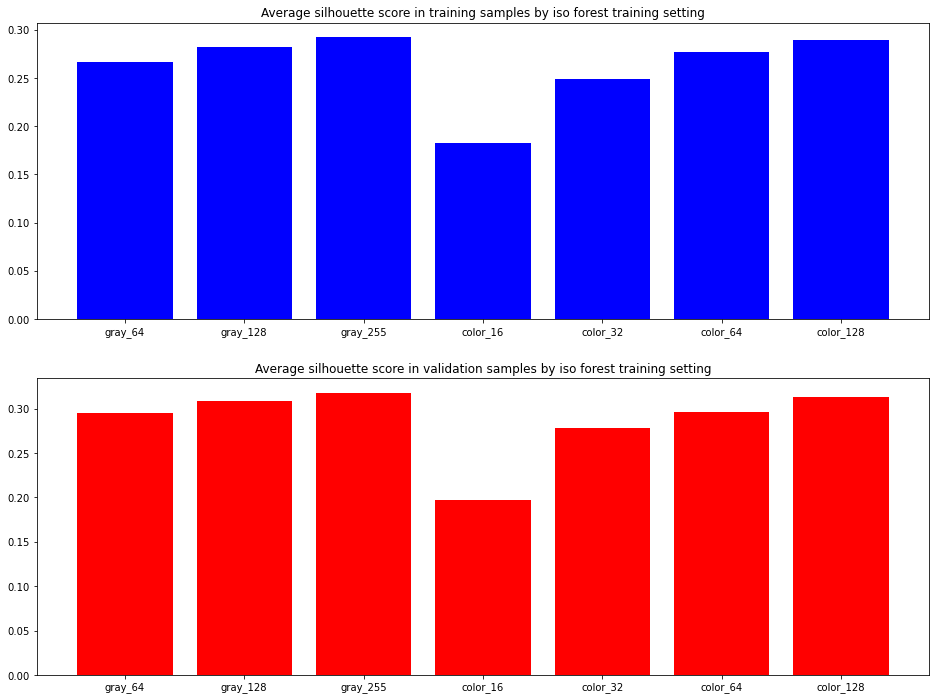

In [25]:
fig, axs = plt.subplots(nrows=2, figsize=(16,12))

axs[0].bar(results_df['model_name'], results_df['train_score']*-1, color='blue')
axs[0].set_title('Average silhouette score in training samples by iso forest training setting')

axs[1].bar(results_df['model_name'], results_df['val_score']*-1, color='red')
axs[1].set_title('Average silhouette score in validation samples by iso forest training setting')

plt.show()


The best model could be fiding less, more homogeneous, outliers. WHich doesn't appear to be the case

In [26]:
pd.Series(models_dict['color_16']['pipeline'].predict(color_train_set)).value_counts()

 1    17505
-1      415
dtype: int64

In [27]:
pd.Series(models_dict['gray_255']['pipeline'].predict(train_set)).value_counts()

 1    17725
-1      195
dtype: int64

### Comparing the Best and the Worst model

We see that the best model, according to the silhouette score is the isolation forest trained on the color images, with 16 histogram bins for each channel. Meanwhile, the most underperforming model is trained on grayscale images with 255 histogram bins.

It might be interesting to see how the model differs and if there is any perceptible difference when plotting the results over the images.

#### Visualizing some training samples

In [28]:
ex_1 = train_imgs[0, :, :].copy()
color_ex_1 = color_train_imgs[0, :, :, :].copy()

In [34]:
ex_1_predictions = prediction_intensities(models_dict['gray_255']['pipeline'], ex_1, (64, 64))
color_ex_1_predictions = prediction_intensities(models_dict['color_16']['pipeline'], color_ex_1, (64, 64, 3))

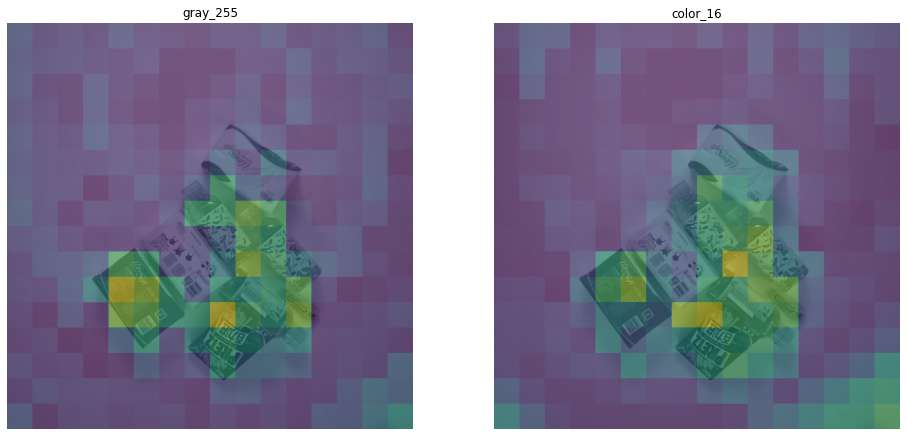

In [41]:
fig, axs = plt.subplots(ncols=2, figsize=(16,12))

ex_img = gray_train_val_images['id'][0]

show_image(ex_img, gray_train_val_images, ax=axs[0])
axs[0].imshow(ex_1_predictions, alpha=0.5)
axs[0].set_title('gray_255')

show_image(ex_img, gray_train_val_images, ax=axs[1])
im = axs[1].imshow(color_ex_1_predictions, alpha=0.5)
axs[1].set_title('color_16')


# fig.colorbar(im, ax=axs)
plt.show()

Let's take a look at more samples

In [46]:
pos_ids = np.random.randint(low=0, high=train_imgs.shape[0], size=3)
train_df = gray_train_val_images.loc[gray_train_val_images['source']=='train']
sample_ids = train_df['id'].iloc[pos_ids].values

It certainly appears to do an okay job on the training set.

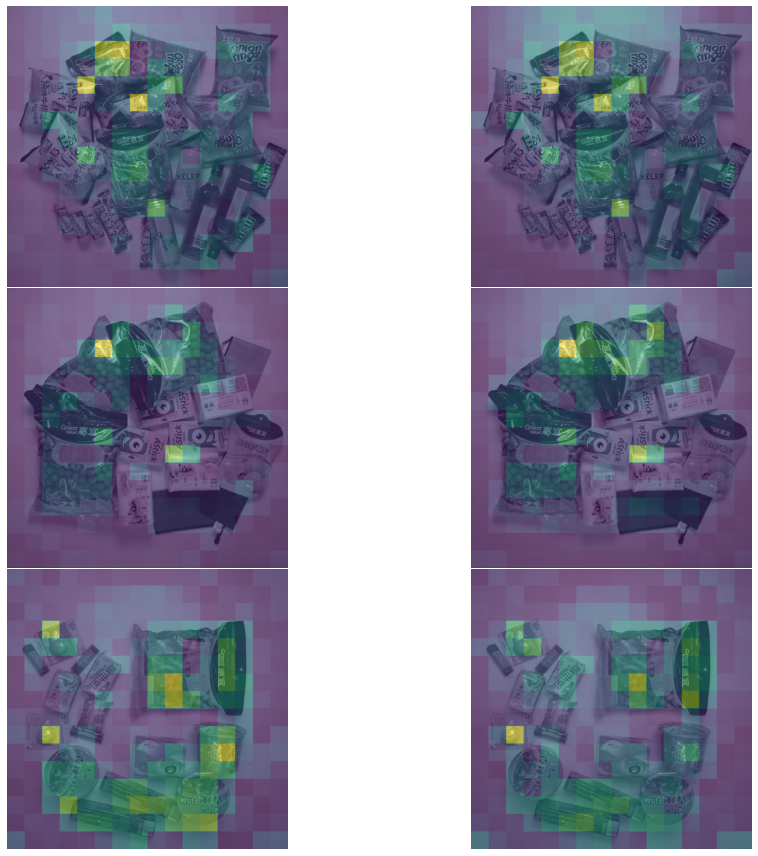

In [55]:
fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(16,12))

axs = axs.flatten()

for pos_id, id, ax, i in zip(np.repeat(pos_ids, 2), np.repeat(sample_ids, 2), axs, range(6)):
    
    if i%2==0:
        predictions = prediction_intensities(models_dict['gray_255']['pipeline'], train_imgs[pos_id], (64, 64))
        ax = show_image(id, gray_train_val_images, ax=ax)
        ax.imshow(predictions, alpha=0.5)
    else:
        predictions = prediction_intensities(models_dict['color_16']['pipeline'], color_train_imgs[pos_id], (64, 64, 3))
        ax = show_image(id, gray_train_val_images, ax=ax)
        ax.imshow(predictions, alpha=0.5)

# fig.colorbar(im, ax=axs[-1], orientation='horizontal')
fig.tight_layout(h_pad=0.1)
plt.show()


But the raw scores might be more interesting

In [22]:
scores = pipeline.score_samples(train_set)

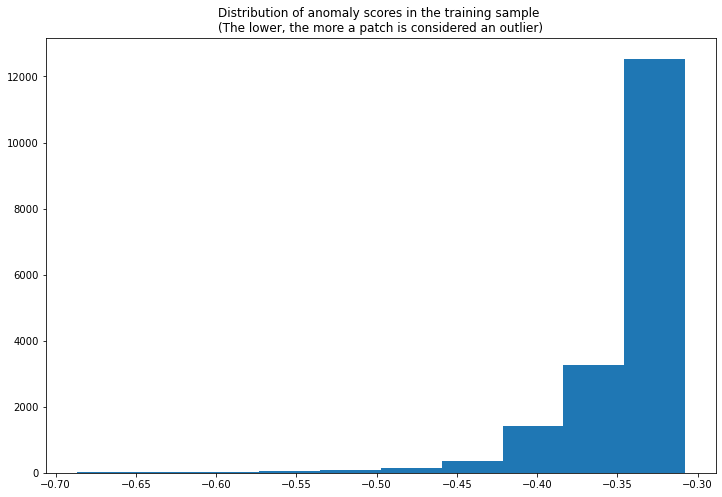

In [23]:
fig, ax = plt.subplots()

ax.hist(scores)
ax.set_title('Distribution of anomaly scores in the training sample \n(The lower, the more a patch is considered an outlier)')

plt.show()

#### Validation sample

On the validation sample, it seems that the model trained on the color images differs from its grayscale counterpart by detencting the same regions, albeit, with more intensity

In [64]:
color_val_df.iloc[i]['id']

23020

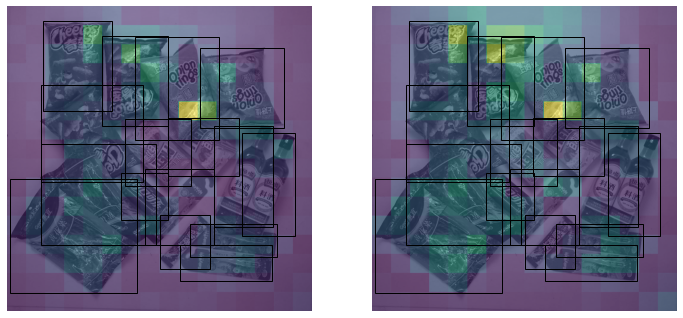

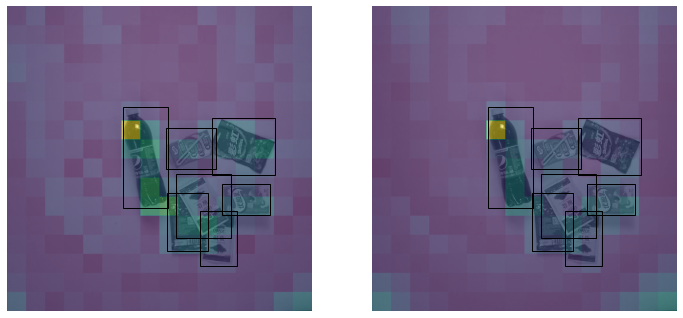

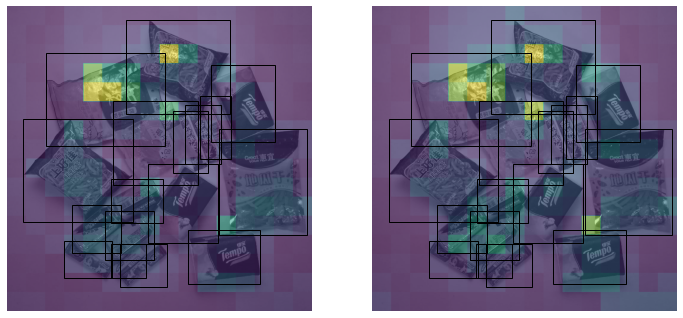

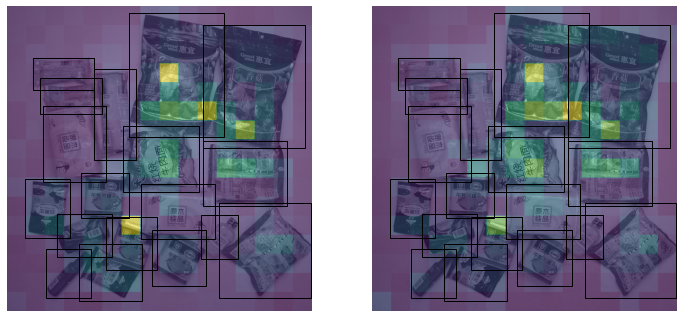

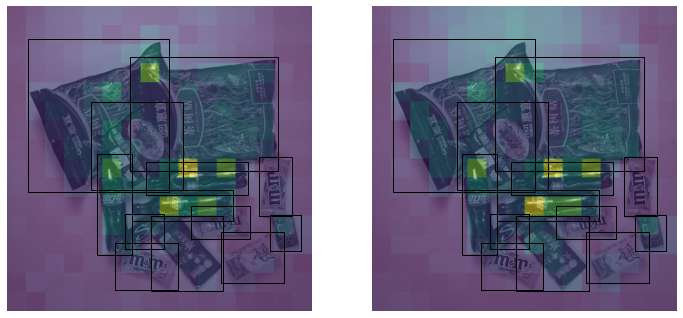

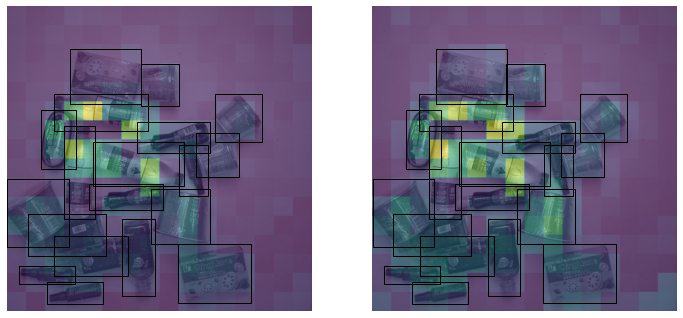

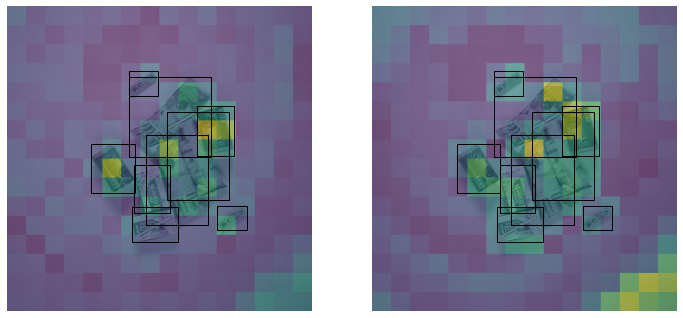

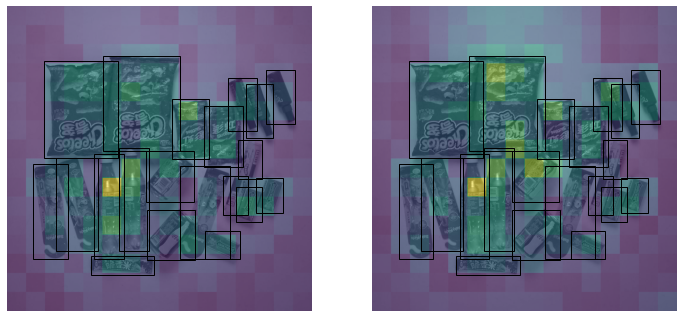

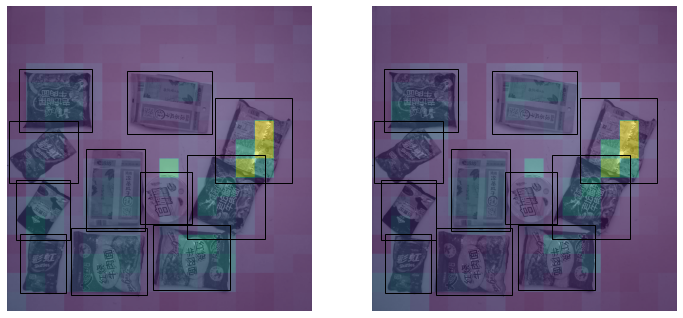

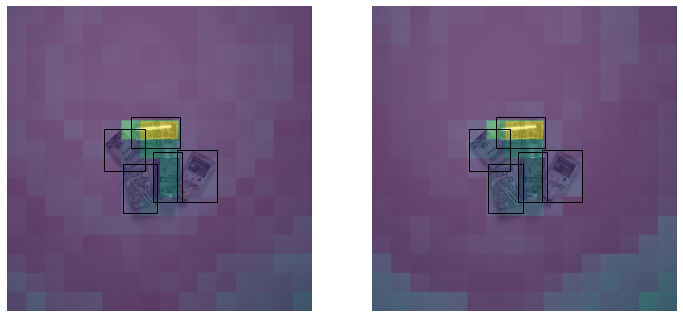

In [79]:
val_df = gray_train_val_images.loc[gray_train_val_images['source']=='validation']
color_val_df = color_train_val_images.loc[color_train_val_images['source']=='validation']

for i in range(10):

    fig, ax = plt.subplots(ncols=2)
    predictions = prediction_intensities(models_dict['gray_255']['pipeline'], val_imgs[i], (64, 64))
    color_predictions = prediction_intensities(models_dict['color_16']['pipeline'], color_val_imgs[i], (64, 64, 3))
    id = val_df.iloc[i]['id']

    # Grayscale on column 0
    show_image(id, gray_train_val_images, True, train_val_annotations, ax=ax[0])
    ax[0].imshow(predictions, alpha=0.5)
    # Color predictions on column 1
    show_image(id, gray_train_val_images, True, train_val_annotations, ax=ax[1])
    ax[1].imshow(color_predictions, alpha=0.5)
    plt.show()


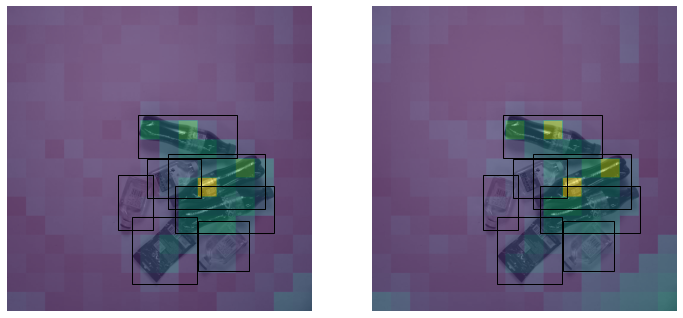

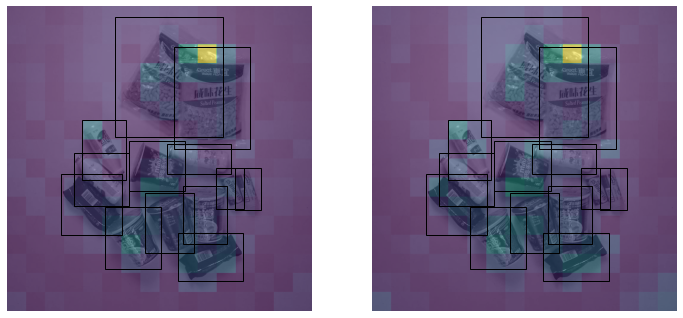

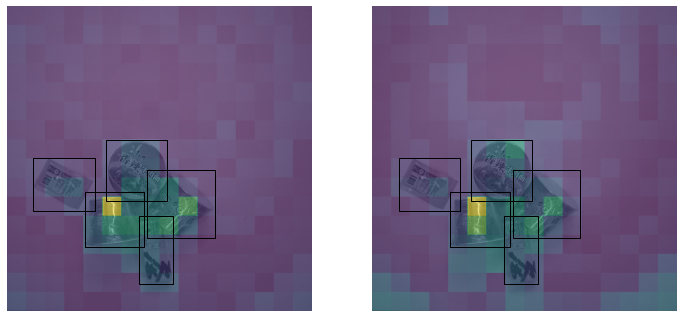

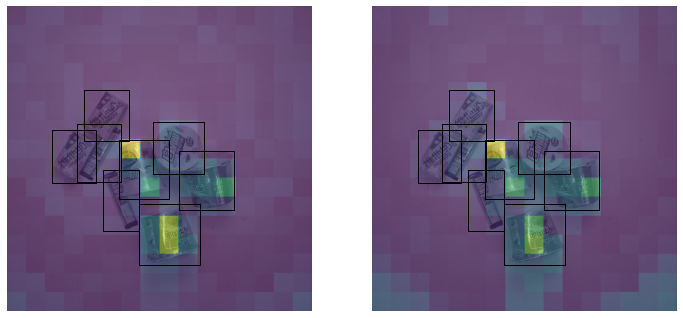

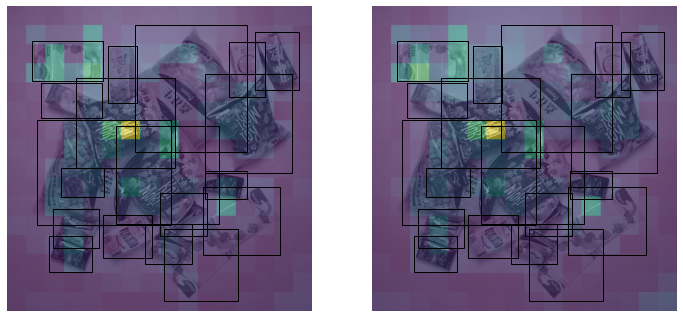

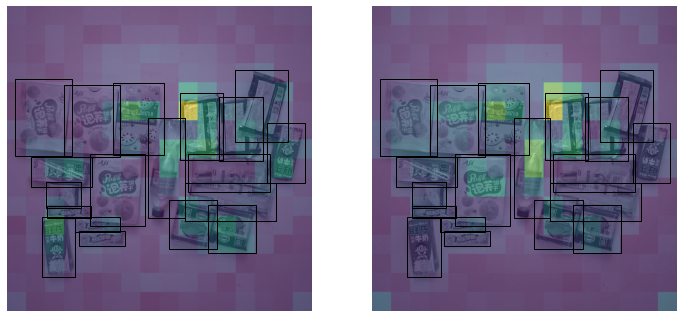

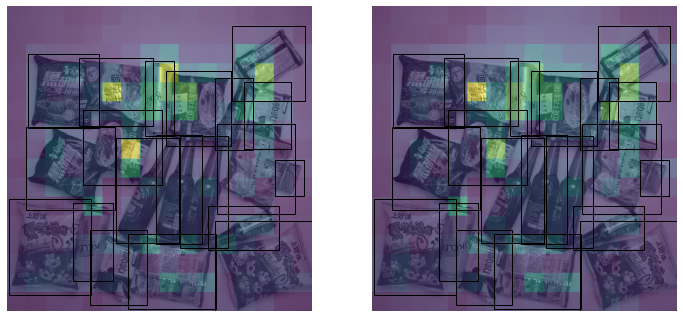

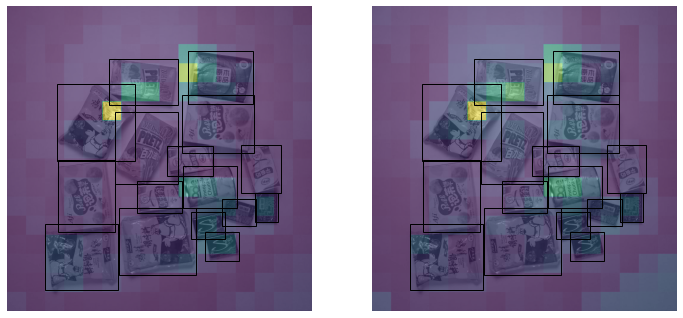

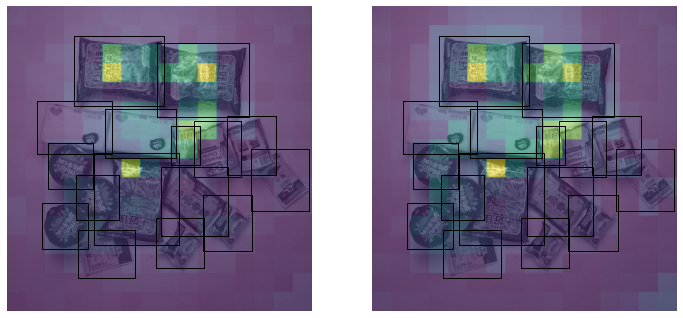

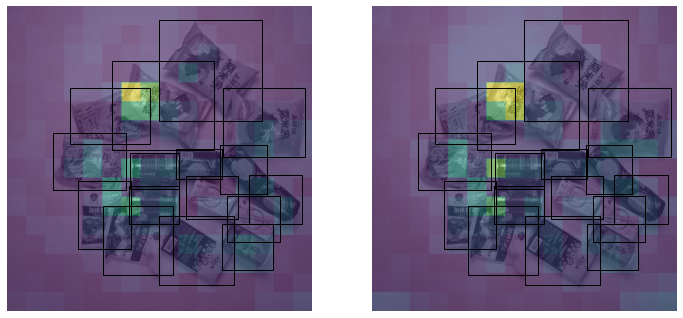

In [80]:
for i in range(10, 20):

    fig, ax = plt.subplots(ncols=2)
    predictions = prediction_intensities(models_dict['gray_255']['pipeline'], val_imgs[i], (64, 64))
    color_predictions = prediction_intensities(models_dict['color_16']['pipeline'], color_val_imgs[i], (64, 64, 3))
    id = val_df.iloc[i]['id']

    # Grayscale on column 0
    show_image(id, gray_train_val_images, True, train_val_annotations, ax=ax[0])
    ax[0].imshow(predictions, alpha=0.5)
    # Color predictions on column 1
    show_image(id, gray_train_val_images, True, train_val_annotations, ax=ax[1])
    ax[1].imshow(color_predictions, alpha=0.5)
    plt.show()